Image: 1040.png, GPR: 1.4, Simplified GPR: 1.4


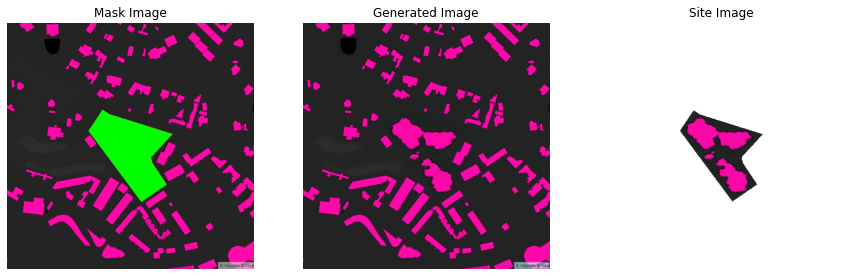

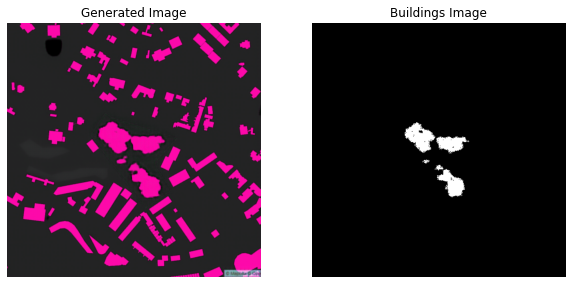

Image: 1074.png, GPR: 2.5, Simplified GPR: 2.8


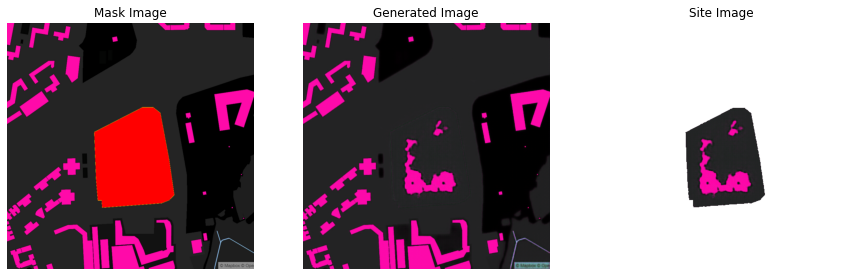

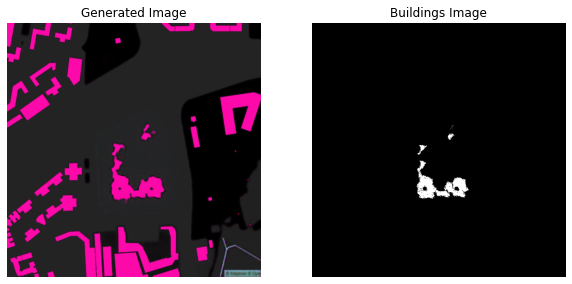

Image: 1076.png, GPR: 2.8, Simplified GPR: 2.8


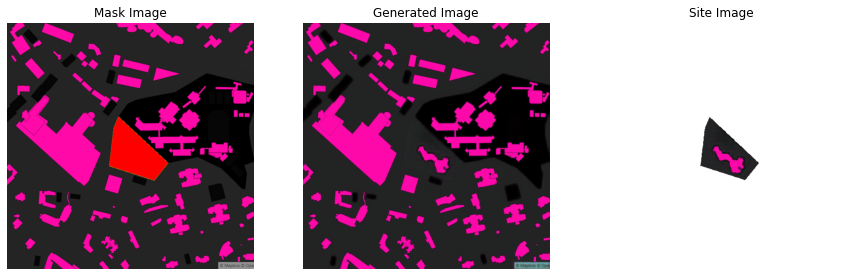

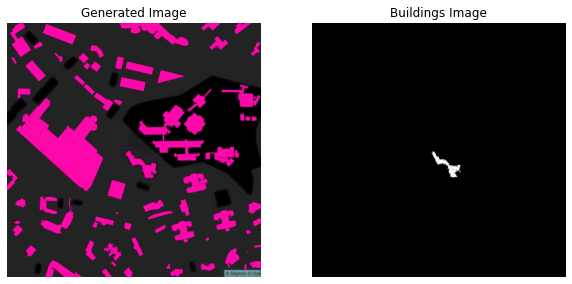

Image: 1102.png, GPR: 1.6, Simplified GPR: 1.6


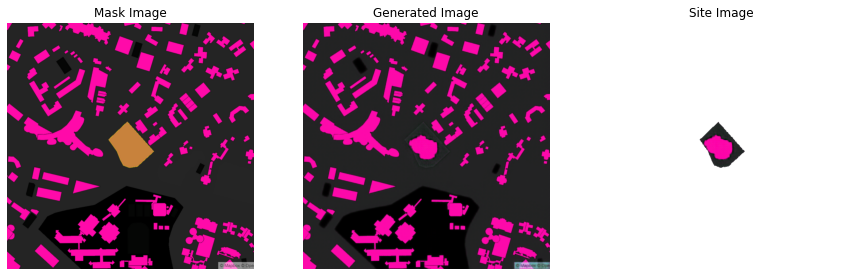

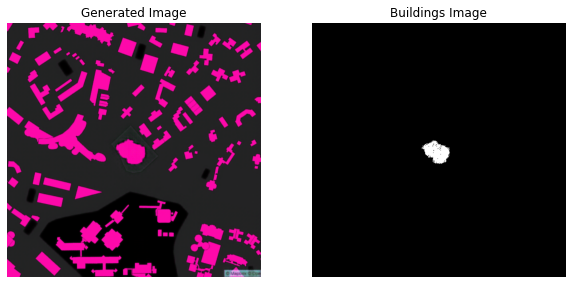

Image: 1180.png, GPR: 3.0, Simplified GPR: 3.0


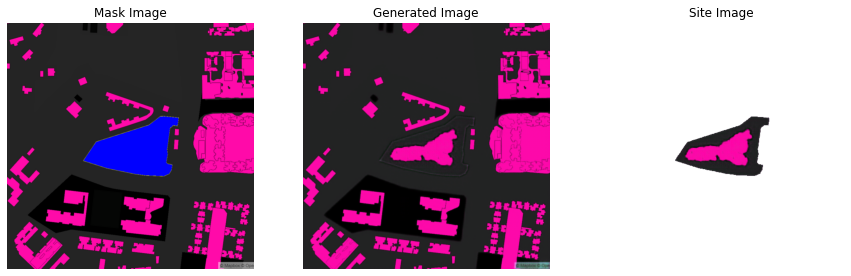

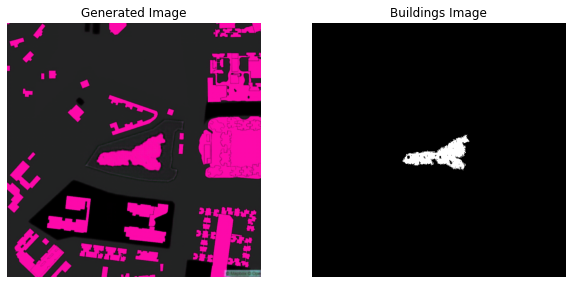

Image: 1379.png, GPR: 1.4, Simplified GPR: 1.4


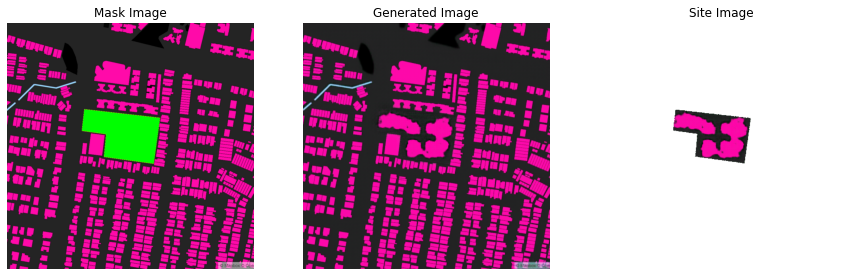

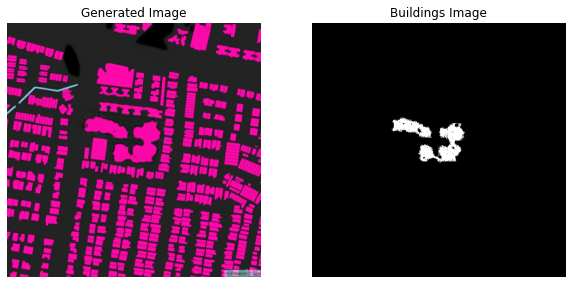

Image: 145.png, GPR: 2.8, Simplified GPR: 2.8


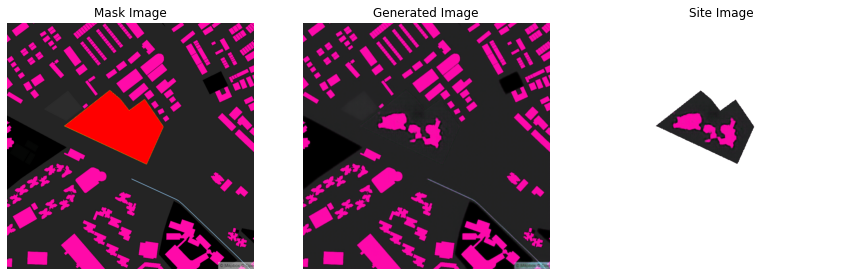

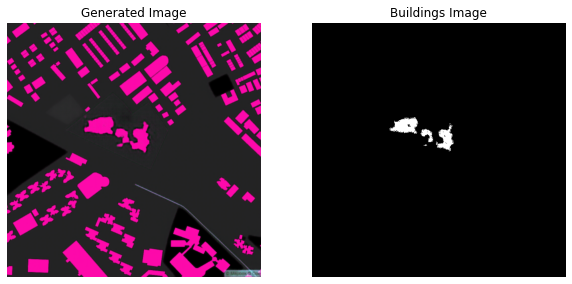

Image: 1484.png, GPR: 3.0, Simplified GPR: 3.0


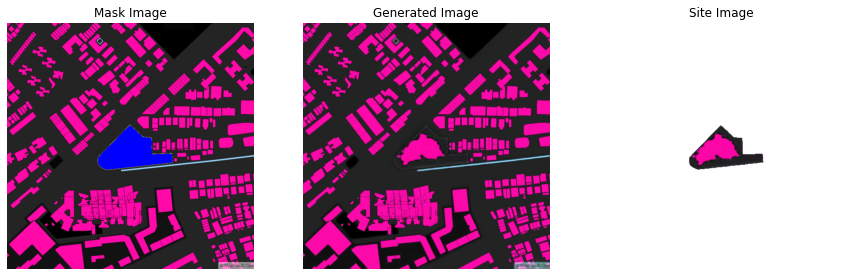

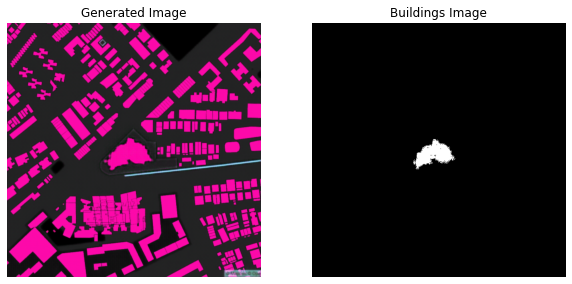

Image: 1602.png, GPR: 3.0, Simplified GPR: 3.0


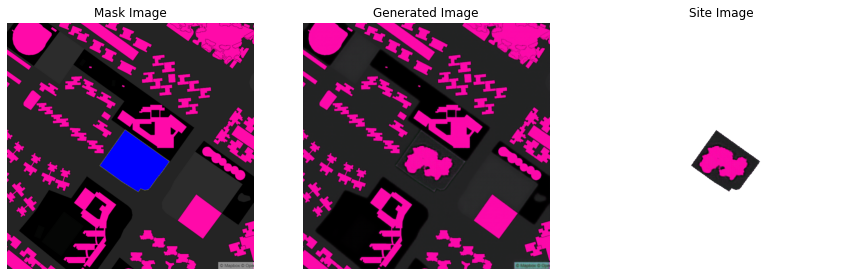

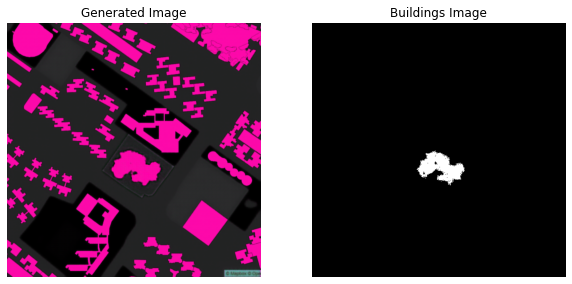

Image: 1655.png, GPR: 2.1, Simplified GPR: 2.1


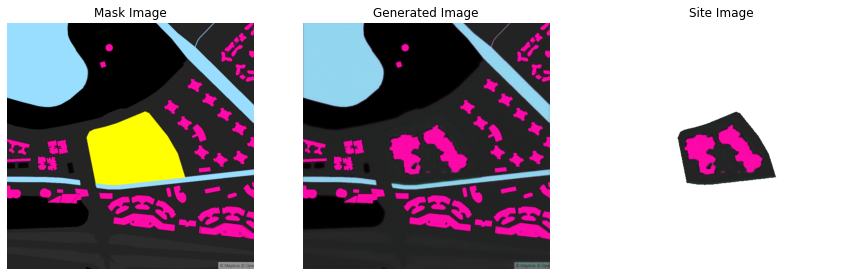

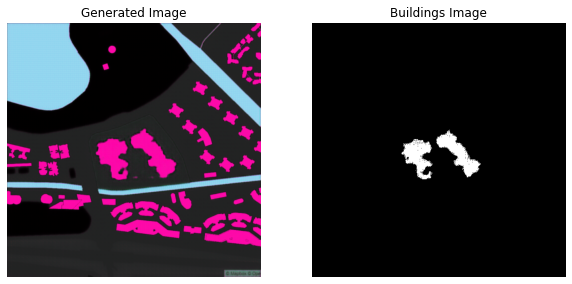

Image: 1670.png, GPR: 2.8, Simplified GPR: 2.8


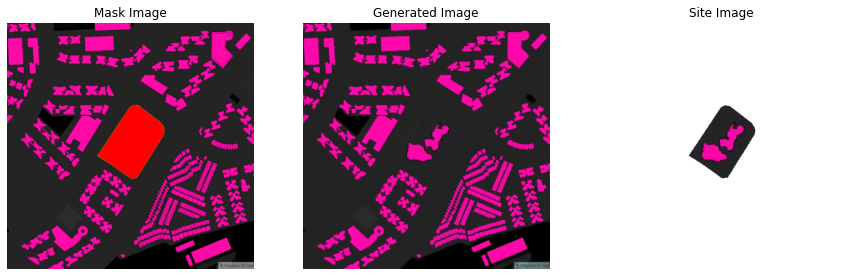

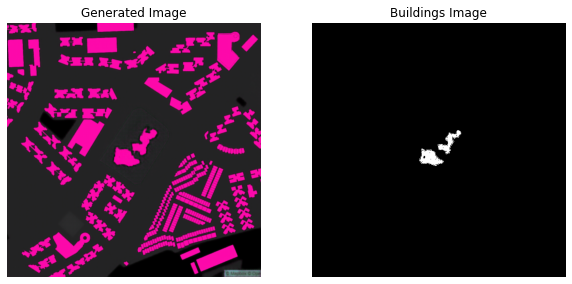

Image: 1796.png, GPR: 2.8, Simplified GPR: 2.8


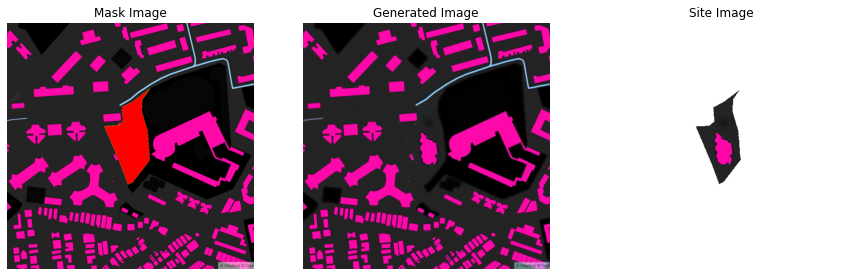

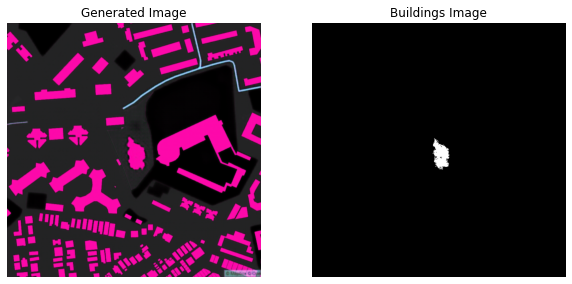

Image: 1811.png, GPR: 1.4, Simplified GPR: 1.4


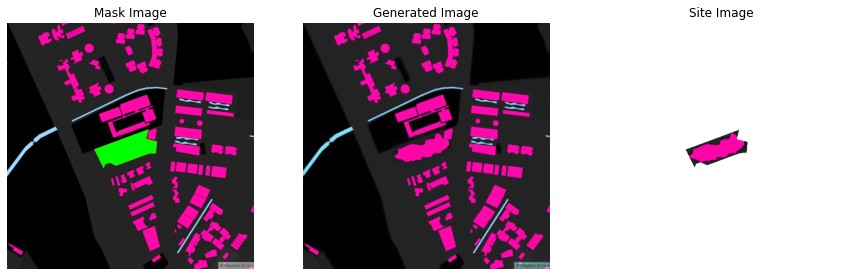

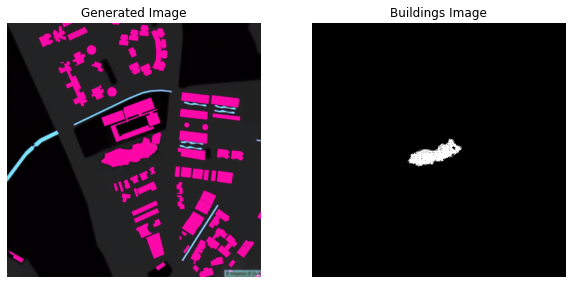

Image: 1876.png, GPR: 2.1, Simplified GPR: 2.1


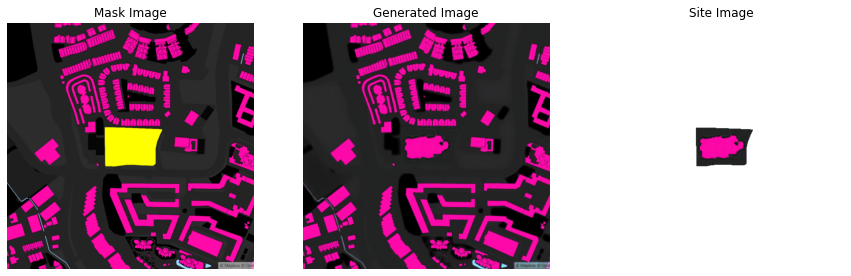

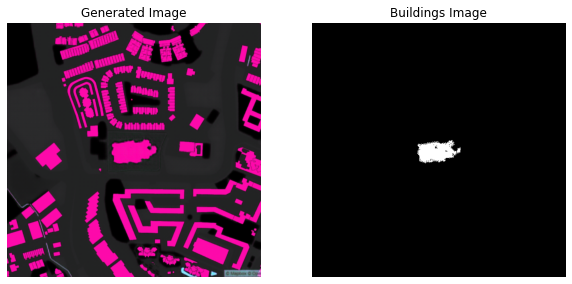

Image: 191.png, GPR: 3.5, Simplified GPR: 3.0


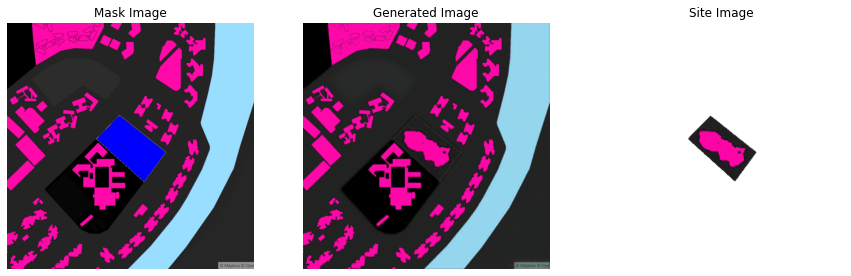

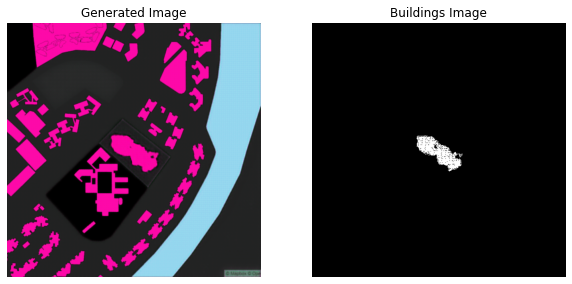

Image: 2000.png, GPR: 3.0, Simplified GPR: 3.0


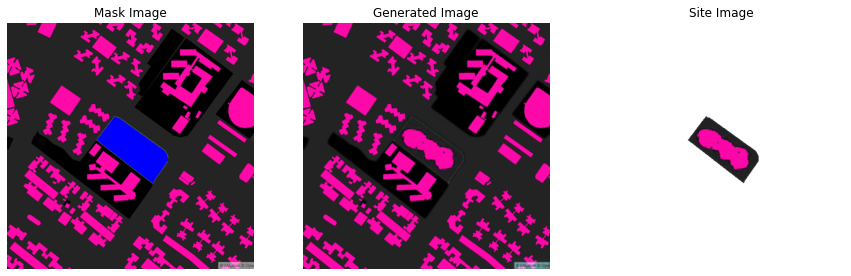

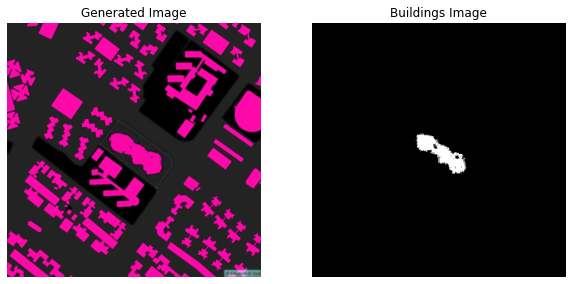

Image: 434.png, GPR: 2.1, Simplified GPR: 2.1


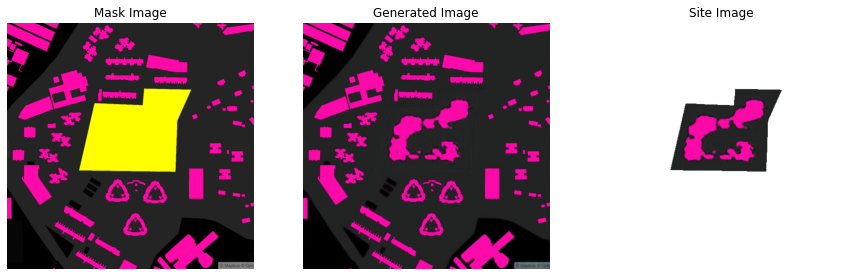

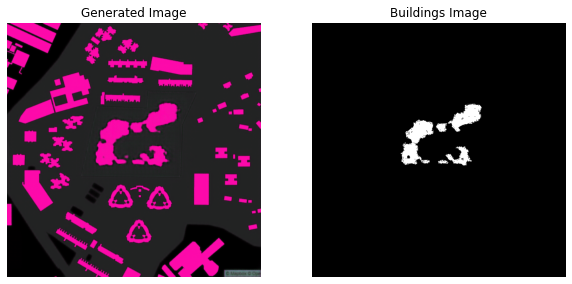

Image: 489.png, GPR: 2.1, Simplified GPR: 2.1


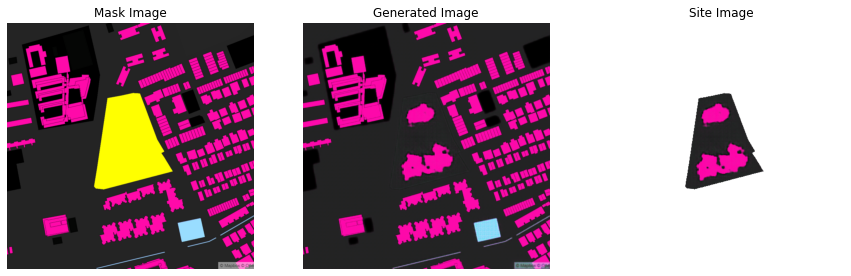

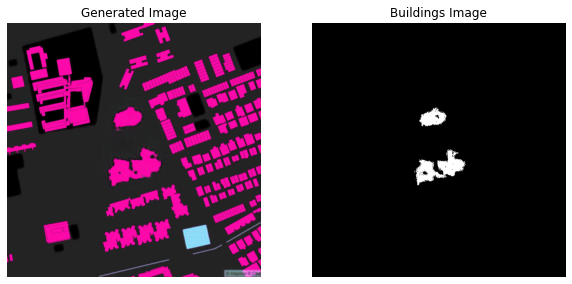

Image: 491.png, GPR: 3.0, Simplified GPR: 3.0


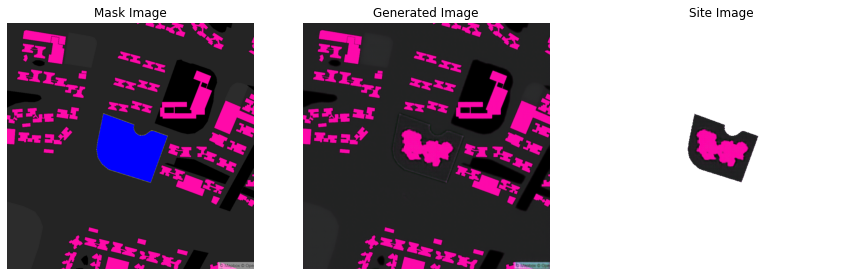

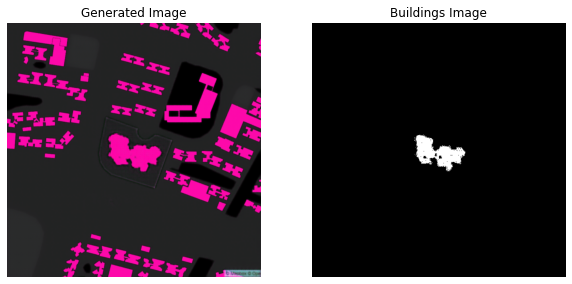

Image: 568.png, GPR: 3.4, Simplified GPR: 3.0


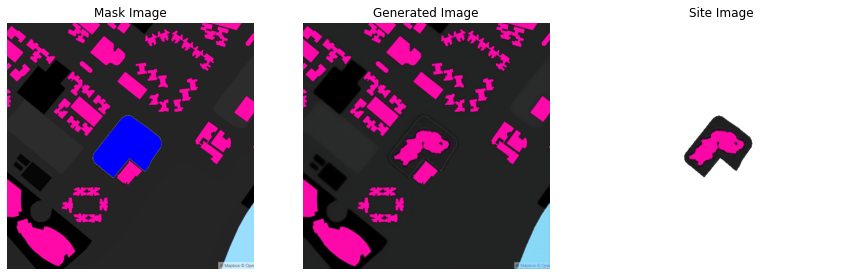

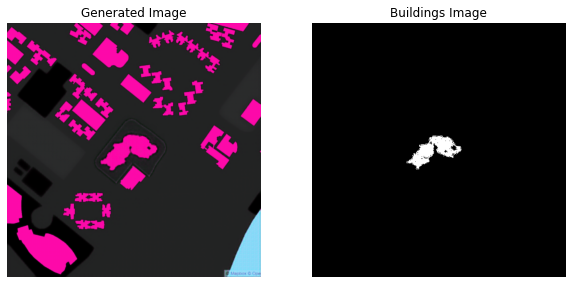

Image: 859.png, GPR: 3.5, Simplified GPR: 3.0


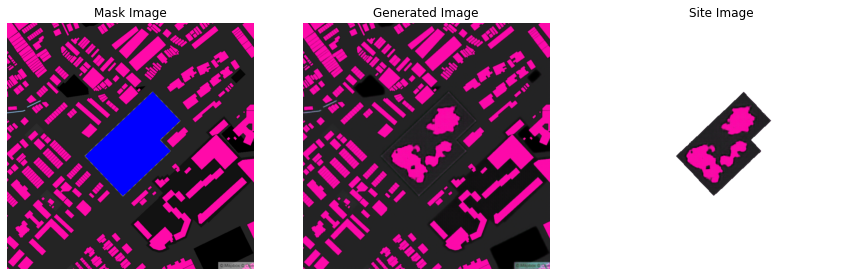

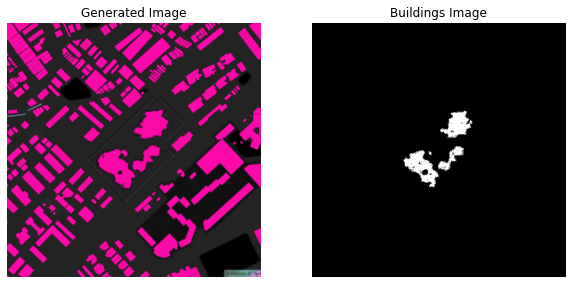

All_Ratio [0.693515311011008, 0.7305782906212264, 0.8089915692035874, 0.7740405697302388, 0.7230777101345475, 0.6898527145549642, 0.7283293504236367, 0.7430846480672668, 0.7232690493040812, 0.7951287830710987, 0.649992753703972, 0.6643991583316519, 0.7006904916134901, 0.7882659862132003, 0.6973685222648709, 0.717651678774789, 0.7287013725330951, 0.7150960263342703, 0.6869072637856175, 0.7216954824316788, 0.8019784350578693]
All_Images ['1040.png', '1074.png', '1076.png', '1102.png', '1180.png', '1379.png', '145.png', '1484.png', '1602.png', '1655.png', '1670.png', '1796.png', '1811.png', '1876.png', '191.png', '2000.png', '434.png', '489.png', '491.png', '568.png', '859.png']
OK_Ratio [0.693515311011008, 0.7305782906212264, 0.7740405697302388, 0.7230777101345475, 0.6898527145549642, 0.7283293504236367, 0.7430846480672668, 0.7232690493040812, 0.7951287830710987, 0.7006904916134901, 0.7882659862132003, 0.6973685222648709, 0.717651678774789, 0.7287013725330951, 0.7150960263342703, 0.68690

In [13]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

import requests
import json
import re
import csv

directory_path = os.getcwd()
parent_directory_path = os.path.dirname(directory_path)
csv_path = os.path.join(parent_directory_path, 'Model\\condo_data_new_FINAL.csv')
gt_masked_image_path = os.path.join(parent_directory_path, 'Model\\clear\\test')
generated_image_path = os.path.join(parent_directory_path, 'Model\\clear\\final_clear_output_1') 

# Read the CSV file
data = pd.read_csv(csv_path)

# Function to extract the numeric part of the filename
def extract_numeric_part(filename):
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part) if numeric_part else None

def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)

def find_max_building_storeys(gpr):
    max_building_storeys= 0
    if gpr >= 0 and gpr < 1.4:
        max_building_storeys = 5
    elif gpr >= 1.4 and gpr < 1.6:
        max_building_storeys = 12
    elif gpr >= 1.6 and gpr < 2.1:
        max_building_storeys = 24
    elif gpr >= 2.1 and gpr < 2.8:
        max_building_storeys = 36
    elif gpr >= 2.8:
        max_building_storeys = 48 ## by right got no limit
    return max_building_storeys

def masked_rgb(simp_gpr):
    rgb = [0,0,0]
    if simp_gpr == 1.4:
        rgb = [0,255,0]
    elif simp_gpr == 1.6:
        rgb = [200,130,60]
    elif simp_gpr == 2.1:
        rgb = [255, 255, 0]
    elif simp_gpr == 2.8:
        rgb = [255,0,0]
    elif simp_gpr == 3.0:
        rgb =[0,0,255]
    return rgb

'''
pink, [255, 10, 169]
brown, [200,130,60]
cyan, [0,255,255]
red, [255,0,0]
black, [0,0,0]
green, [0,255,0]
blue, [0,0,255]
yellow, [255, 255, 0]
'''

ok_ratio = []
ok_images = []
all_images = []
all_ratio =[]

# Iterate through the images in the generated_image_path
for image_file in os.listdir(generated_image_path):
    if image_file.endswith('.png'):
        image_index = extract_numeric_part(image_file)

        # Construct the path for the corresponding masked image
        gt_mask_image_filename = f"{image_index}.png"
        gt_mask_image = os.path.join(gt_masked_image_path, gt_mask_image_filename)
        open_gt_mask_image = Image.open(gt_mask_image)
        crop_box = (512, 0, 1024, 512) # right side
        mask_image = open_gt_mask_image.crop(crop_box) #gt_mask is concatenated gt and mask

        generated_image = os.path.join(generated_image_path, image_file)
        generated_image = generated_image =  Image.open(generated_image)

        # Check if the image index matches any index in the CSV
        matched_row = data[data['key1'] == image_index]
        if not matched_row.empty:
            # Extract the GPR value for the matched row
            gpr_value = matched_row['GPR'].iloc[0]
            simplified_gpr_value = matched_row['simp_gpr'].iloc[0]
            actual_site_area = matched_row['area'].iloc[0]
            actual_site_area = actual_site_area.replace(',', '')
            actual_site_area = float(actual_site_area[:-4])
            gpr_value = float(gpr_value)

            print(f'Image: {image_file}, GPR: {gpr_value}, Simplified GPR: {simplified_gpr_value}')

            mask_array = np.array(mask_image)
            generated_array = np.array(generated_image)

            mask_color = masked_rgb(simplified_gpr_value)
            site_mask = create_binary_mask(mask_array, mask_color)
            site_area_array = generated_array.copy()
            site_area_array[~site_mask] = [255, 255, 255, 255] # making non-masked region white RMB ITS 4 CHANNELS NOW
            site_area_image = Image.fromarray(site_area_array)
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(mask_image)
            plt.title('Mask Image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(generated_image)
            plt.title('Generated Image')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(site_area_image)
            plt.title('Site Image')
            plt.axis('off')
            plt.show()

            mask_color = [255, 10, 169] # pink
            building_mask = extract_building_regions(site_area_array, mask_color)
            buildings_image = Image.fromarray(building_mask)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(generated_image)
            plt.title('Generated Image')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(buildings_image, cmap='gray')
            plt.title('Buildings Image')
            plt.axis('off')
            plt.show()

            # find site:building area ratio
            mask_pixels = np.sum(site_mask)
            ratio = float(mask_pixels/actual_site_area)
            all_ratio.append(ratio)
            all_images.append(image_file)
            if ratio <= 0.8 and ratio >= 0.68:
                ok_ratio.append(ratio)
                ok_images.append(image_file)
print('All_Ratio', all_ratio)
print('All_Images', all_images)
print('OK_Ratio', ok_ratio)
print('OK_Images', ok_images)